Text Summarization Model Training

This notebook demonstrates the process of training a text summarization model using the provided dataset.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import sys
from pathlib import Path
import os
import ijson
import json


# Add the project root directory to Python path
project_root = str(Path.cwd().parent) if 'notebooks' in str(Path.cwd()) else str(Path.cwd())
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
from src.preprocessing import load_data, preprocess_data, split_and_save_data
from src.model import initialize_model, train_model, save_model, summarize
from src.evaluation import calculate_rouge, calculate_bleu
from src.visualizations import plot_loss

c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\TinyLLaMa-Summarization\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define paths
raw_data_path = r"C:\Users\ELITEBOOK\OneDrive\Desktop\Projects\TinyLLaMa-Summarization\data\raw\sample.jsonl"
processed_data_dir = "../data/processed"

# Load and preprocess data
print("Loading raw data...")
raw_data = load_data(raw_data_path)

print("Preprocessing data...")
articles, summaries = preprocess_data(raw_data)

# Split and save processed data
print("Splitting and saving processed data...")
split_and_save_data(articles, summaries, output_dir=processed_data_dir)

print(f"Number of articles: {len(articles)}")
print(f"Sample article length: {len(articles[0])} characters")
print(f"Sample summary length: {len(summaries[0])} characters")

Loading raw data...
Preprocessing data...
Splitting and saving processed data...
Train and test datasets saved in ../data/processed
Number of articles: 1000000
Sample article length: 2226 characters
Sample summary length: 0 characters


Loading training data...
Initializing model...
Training model...
Epoch 1, No batches processed
Epoch 2, No batches processed
Epoch 3, No batches processed
Epoch 4, No batches processed
Epoch 5, No batches processed


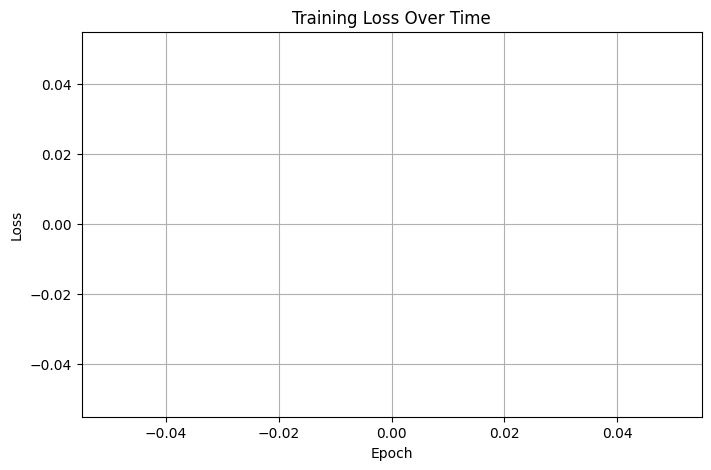

In [3]:
# Load training data
print("Loading training data...")
with open(os.path.join(processed_data_dir, "train.json"), "r") as f:
    train_data = []
    parser = ijson.parse(f)
    for prefix, event, value in parser:
        if prefix.endswith('.article'):
            article = value
            # Find the corresponding summary
            summary_prefix = prefix.replace('.article', '.summary')
            summary = next((item[2] for item in parser if item[0] == summary_prefix), None)
            if summary is not None:
                train_data.append({'article': article, 'summary': summary})
    train_data = train_data[:100000]  # Limit to 100000 samples

# Initialize model
print("Initializing model...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model, tokenizer = initialize_model(model_name)

# Train model
print("Training model...")
training_stats = train_model(model, tokenizer, train_data, epochs=5)

# Plot training loss
plot_loss(training_stats['losses'])

In [4]:
# Load test data
print("Loading test data...")
with open(os.path.join(processed_data_dir, "test.json"), "r") as f:
    test_data = json.load(f)

# Evaluate on sample from test set
print("\nEvaluating model on sample test data:")
rouge_scores = []
bleu_scores = []

for idx, item in enumerate(test_data[:5]):  # Evaluate first 5 examples
    print(f"\nExample {idx + 1}:")

    # Generate summary
    generated_summary = summarize(model, tokenizer, item['article'])

    # Calculate metrics
    rouge = calculate_rouge(item['summary'], generated_summary)
    bleu = calculate_bleu(item['summary'], generated_summary)

    rouge_scores.append(rouge)
    bleu_scores.append(bleu)

    print(f"Article: {item['article'][:200]}...")
    print(f"Generated Summary: {generated_summary}")
    print(f"Reference Summary: {item['summary']}")
    print(f"ROUGE Scores: {rouge}")
    print(f"BLEU Score: {bleu}")

# Calculate and display average scores
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])
avg_bleu = np.mean(bleu_scores)

print("\nAverage Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")
print(f"BLEU: {avg_bleu:.4f}")


Loading test data...

Evaluating model on sample test data:

Example 1:


c:\Users\ELITEBOOK\OneDrive\Desktop\Projects\TinyLLaMa-Summarization\myenv\Lib\site-packages\transformers\generation\configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


ValueError: The following `model_kwargs` are not used by the model: ['num_eams'] (note: typos in the generate arguments will also show up in this list)

In [ ]:
# Create results dictionary
results = {
    'average_scores': {
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL,
        'bleu': avg_bleu
    },
    'example_predictions': [
        {
            'article': item['article'],
            'reference_summary': item['summary'],
            'generated_summary': summarizer.summarize(item['article']),
        }
        for item in test_data[:5]
    ]
}

# Save results
os.makedirs('../reports', exist_ok=True)
with open('../reports/evaluation_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Evaluation results saved to reports/evaluation_results.json")

In [ ]:

# Save model
print("Saving model...")
save_model(model, tokenizer, "../models/tiny-llama-model")